# Upper Confidence Bound BO


In [1]:
# Import the class

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import torch
import yaml

import matplotlib.pyplot as plt
from xopt import Xopt

## Customizing the UpperConfidenceBound Generator
First lets examine the possible options that we can specify for the
UpperConfidenceBound generator. We can use these keys to customize optimization.

In [2]:
from xopt.generators import get_generator_and_defaults
gen, options = get_generator_and_defaults("upper_confidence_bound")
print(yaml.dump(options.dict()))

acq:
  beta: 2.0
  monte_carlo_samples: 128
  proximal_lengthscales: null
  use_transformed_proximal_weights: true
model:
  covar_modules: {}
  custom_constructor: null
  mean_modules: {}
  name: standard
  use_low_noise_prior: true
n_initial: 3
optim:
  max_travel_distances: null
  num_restarts: 20
  raw_samples: 20
  sequential: true
  use_turbo: false
use_cuda: false



The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
# Make a proper input file.
YAML = """
xopt: 
    dump_file: dump.yaml
generator:
  name: upper_confidence_bound
  n_initial: 2
  acq:
    beta: 0.1

evaluator:
  function: xopt.resources.test_functions.sinusoid_1d.evaluate_sinusoid

vocs:
  variables:
    x1: [0, 6.28]
  objectives:
    y1: 'MINIMIZE'
"""
config = yaml.safe_load(YAML)

In [4]:
X = Xopt(config=config)
X


            Xopt
________________________________
Version: 0+untagged.1.gb4c7d50
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: dump.yaml, max_evaluations: null}
generator:
  name: upper_confidence_bound
  optim: {num_restarts: 20, raw_samples: 20, sequential: true, max_travel_distances: null,
    use_turbo: false}
  acq: {proximal_lengthscales: null, use_transformed_proximal_weights: true, monte_carlo_samples: 128,
    beta: 0.1}
  model:
    name: standard
    custom_constructor: null
    use_low_noise_prior: true
    covar_modules: {}
    mean_modules: {}
  n_initial: 2
  use_cuda: false
evaluator:
  function: xopt.resources.test_functions.sinusoid_1d.evaluate_sinusoid
  max_workers: 1
  function_kwargs: {}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 6.28]
  constraints: {}
  objectives: {y1: MINIMIZE}
  constants: {}
  linked_variables: {}


## Run Optimization

In [5]:
for i in range(5):
    print(i)
    X.step()

0
1
2
3
4


## View output data

In [6]:
X.data

,x1,y1,c1,xopt_runtime,xopt_error
1,1.099809,0.891121,0.399167,0.000019,False
2,2.230325,0.790281,-1.501649,0.000004,False
3,3.474834,-0.327108,-13.494609,0.000017,False
4,4.818134,-0.994414,-18.705820,0.000015,False
5,5.669259,-0.576081,-14.345659,0.000016,False
6,4.599085,-0.993588,-18.734260,0.000016,False


## Visualize model used by upper confidence bound
Models are kept in a list, in this case that list has one element, the model
created for the objective `y1`.


Text(0, 0.5, 'y1')

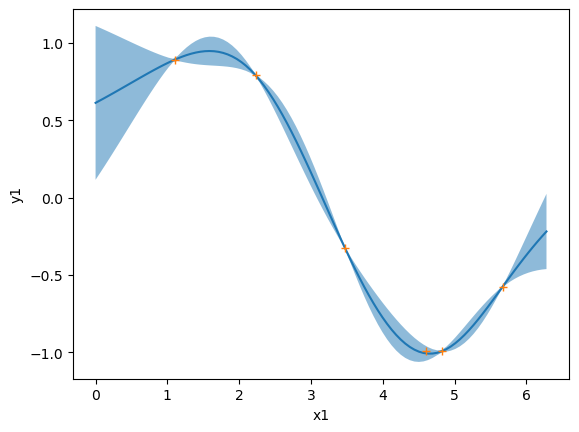

In [7]:
model = X.generator.model
bounds = X.vocs.bounds

test_x = torch.linspace(*bounds.flatten(), 100).double()

train_x = torch.tensor(X.data["x1"].to_numpy())
train_y = torch.tensor(X.data["y1"].to_numpy())

fig, ax = plt.subplots()
with torch.no_grad():
    post = model.models[0].posterior(test_x.reshape(-1,1,1))
    mean = post.mean.flatten()
    std = post.variance.sqrt().flatten()

    lower = mean - std
    upper = mean + std

ax.plot(test_x, mean)
ax.fill_between(test_x, lower, upper, alpha=0.5)
ax.plot(
    train_x.flatten(),
    train_y.flatten(),
    "+"
)
ax.set_xlabel("x1")
ax.set_ylabel("y1")


In [8]:
# Cleanup
!rm dump.yaml